In [305]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils import plot_images
from image_datasets import load_nist_data

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from torch.utils.data import DataLoader
from utils import plot_images
from image_datasets import load_nist_data
from torchvision.utils import make_grid

def mnist_grid(sample, title=None, xlabel=None, num_img=5, nrow=8, figsize=(10,10), save=False):
    _, ax= plt.subplots(1,1, figsize=figsize)
    sample = sample[:num_img]
    img = make_grid(sample, nrow=nrow)
    npimg = np.transpose(img.detach().cpu().numpy(),(1,2,0))
    plt.imshow(npimg)
    plt.title(title)
    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])
    if save:
        plt.savefig( 'images/' + title + '.png', bbox_inches='tight', dpi=2000)
    plt.show()


def get_10_digits(images, labels):
  digits={}
  for i in range(10):
      digits[i] = images[labels == i]
  digits = torch.cat([
                    digits[1][0],
                    digits[2][0],
                    digits[3][0],
                    digits[4][0],
                    digits[5][0],
                    digits[6][0],
                    digits[7][0],
                    digits[8][0],
                    digits[9][0]
                    ], dim=0)  
  digits = digits.unsqueeze(1)
  return digits


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
# Assume make_grid is already defined/imported


def plot_combined_with_mnist_grid(samples, fcd_3, fcd_avg, distortion, dist_levels, xlim=(0,100), titles=None, loc='upper left', log=False, figsize=(10, 6)):
    N = len(samples)
    if titles is None: titles = [None] * N
    _ = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, N+2, width_ratios=[0.75]*N+[0.3, 1.5], wspace=0.)  # Added a spacing column with width 0.1    
    axs = [plt.subplot(gs[i]) for i in range(N)] + [plt.subplot(gs[N+1])]  # Skip the spacing column for actual plots

    #...plot each mnist sample:
    for i, sample in enumerate(samples):
        img = make_grid(sample[:9], nrow=3)
        npimg = np.transpose(img.detach().cpu().numpy(), (1, 2, 0))
        axs[i].imshow(npimg)
        axs[i].set_xlabel(dist_levels[i], fontsize=8) if i > 0 else axs[i].set_xlabel('', fontsize=8)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        if titles:
            axs[i].set_title('+  '+distortion, fontsize=11) if i > 0 else axs[i].set_title('Binarized MNIST', fontsize=11)

    #...plot FCD:
    axs[N].plot(list(fcd_3.keys()), list(fcd_3.values()), color='darkred', label='last conv. layer')
    axs[N].plot(list(fcd_avg.keys()), list(fcd_avg.values()), color='darkred', ls='--', label='avg. layers')
    axs[N].set_ylabel(r'FCD', fontsize=9)
    axs[N].set_xlabel('Corruption level', fontsize=9)
    axs[N].legend(loc=loc, fontsize=8)
    axs[N].set_ylim(1,800)
    axs[N].set_xlim(xlim)
    if log:
        axs[N].set_yscale('log')
        axs[N].set_ylim(1, 5000)
        axs[N].set_yticks([1, 10, 100, 1000, 10000])
        axs[N].get_yaxis().set_major_formatter(plt.ScalarFormatter())
        axs[N].set_yticklabels(['1', '10', '100', '1000', r'$10^4$'])

    plt.tight_layout()
    plt.savefig(distortion + '_combined_plot.png', bbox_inches='tight', dpi=500)
    plt.show()


In [66]:
[None]*3

[None, None, None]

## Perturbed Binirezed MNIST 

We first define the reference sample as binarized MNIST (with binarization threshold of 0.5)

We now define the following perturbations:
- Pepper MNIST with binarizing thresholds different than 0.5 
- Gaussian noise 
- Gaussian Blurr
- Swirl deformation

We will later compute the FID between these datasets and the reference Pepper MNIST (binerized threshold=0.5) 

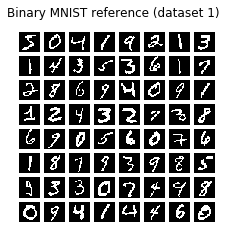

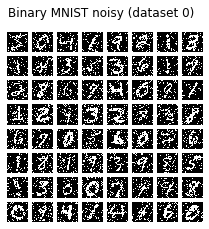

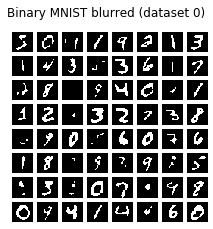

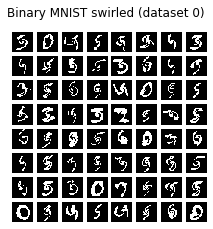

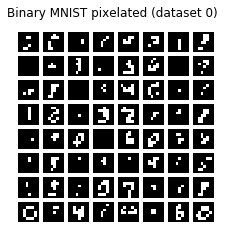

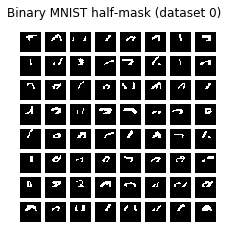

In [12]:
cmap='bone'

#...Reference dfataset:

data = load_nist_data(name='BinaryMNIST')
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Binary MNIST reference (dataset 1)", figsize=(3.5, 3.5), cmap=cmap)

#...Distorted datasets:

data = load_nist_data(name='BinaryMNIST', distortion='noise', level=0.4)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Binary MNIST noisy (dataset 0)", figsize=(3.5, 3.5), cmap=cmap)


data = load_nist_data(name='BinaryMNIST', distortion='swirl', level=5)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Binary MNIST swirled (dataset 0)", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='BinaryMNIST', distortion='pixelize', level=0.7)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Binary MNIST pixelated (dataset 0)", figsize=(3.5, 3.5), cmap=cmap)


data = load_nist_data(name='BinaryMNIST', distortion='half_mask')
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Binary MNIST half-mask (dataset 0)", figsize=(3.5, 3.5), cmap=cmap)


##  LeNet-5 classifier for MNIST & Binary-MNIST
We load two pre-trained LeNet-5 classifiers and evaluate them on the Reference MNIST datasets to extract the mean and std of the features of intermediate layers. We look into two cases: 1) The standard MNIST dataset and 2) the "Pepper" or binarized MNIST dataset.

The trained LeNet-5 classifiers have classification accuracies above 98%.

In [5]:
import torch
from architectures import LeNet5
from fid_metric import compute_activation_statistics, fid_distorted_NIST

device = 'cuda:0'
model_bin = LeNet5(num_classes=10)
model_bin.load_state_dict(torch.load('models/LeNet5_BinaryMNIST.pth'))
model_bin.eval()

#...Load MNIST test dataset

test_ref = load_nist_data(name='BinaryMNIST', train=False)


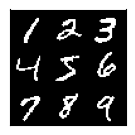

In [102]:
data_ref = load_nist_data(name='BinaryMNIST', distortion='crop', level=0)
dataloader = DataLoader(data_ref, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits = get_10_digits(images, labels)

mnist_grid(digits, num_img=9,  nrow=3, figsize=(1.5,1.5))

## FID Experiments with LeNet-5

Below we compute the FID metric between the reference MNIST data and various distortion levels.
For the classifier we used the LeNet-5 architecture as above. We show that the FID computed from 
features in the second layer has a better separation power than the featuires extracted from
the first and third layers accross all considered deformation. 

### 1. Gaussian noise

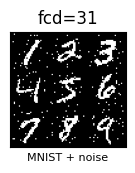

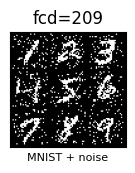

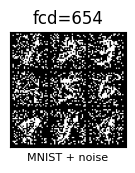

In [313]:
level_1 = 0.26
distortion = 'noise'

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_1)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='noise', values=[level_1], activation_layer='fc3', device=device)
fcd_1 = int(fcd[level_1].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_noise_1 = get_10_digits(images, labels)
mnist_grid(digits_noise_1, title='fcd={}'.format(fcd_1), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

level_2 = 0.38

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_2)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='noise', values=[level_2], activation_layer='fc3', device=device)
fcd_2 = int(fcd[level_2].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_noise_2 = get_10_digits(images, labels)
mnist_grid(digits_noise_2, title='fcd={}'.format(fcd_2), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

level_3 = 0.65

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_3)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='noise', values=[level_3], activation_layer='fc3', device=device)
fcd_3 = int(fcd[level_3].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_noise_3 = get_10_digits(images, labels)
mnist_grid(digits_noise_3, title='fcd={}'.format(fcd_3), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

In [165]:
import numpy as np
from fid_metric import fid_distorted_NIST

fcd_1_noise = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='noise', values=np.arange(0.0, 1, 0.05), activation_layer='fc1', device=device)
fcd_2_noise  = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='noise', values=np.arange(0.0, 1, 0.05), activation_layer='fc2', device=device)
fcd_3_noise  = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='noise', values=np.arange(0.0, 1, 0.05), activation_layer='fc3', device=device)
fcd_avg_noise  = {k: (fcd_1_noise.get(k, 0) + fcd_2_noise.get(k, 0) + fcd_3_noise.get(k, 0) ) / 3.0 for k in fcd_1_noise.keys()}

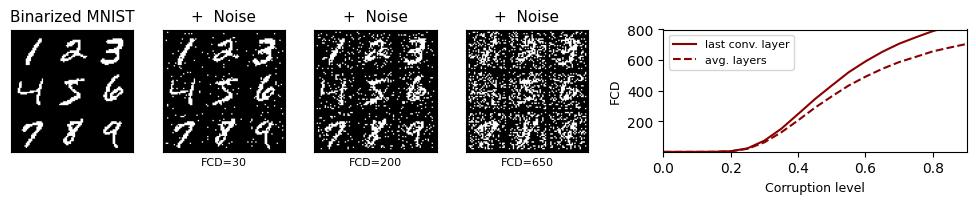

In [315]:
# make grid plots:

plot_combined_with_mnist_grid(samples=[digits, digits_noise_1, digits_noise_2, digits_noise_3], 
                              fcd_3=fcd_3_noise, 
                              fcd_avg=fcd_avg_noise, 
                              distortion='Noise', 
                              xlim=(0, 0.9),
                              dist_levels=['FCD=0', 'FCD={}'.format(30), 'FCD={}'.format(200), 'FCD={}'.format(650)],
                             figsize=(10, 2))

### 2. Gaussian blur

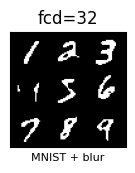

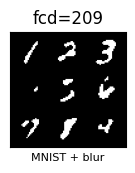

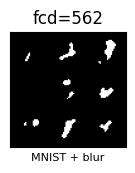

In [303]:

level_1 = 1.25
distortion = 'blur'

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_1)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion=distortion, values=[level_1], activation_layer='fc3', device=device)
fcd_1 = int(fcd[level_1].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_blur_1 = get_10_digits(images, labels)
mnist_grid(digits_blur_1, title='fcd={}'.format(fcd_1), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

level_2 = 1.85

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_2)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion=distortion, values=[level_2], activation_layer='fc3', device=device)
fcd_2 = int(fcd[level_2].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_blur_2 = get_10_digits(images, labels)
mnist_grid(digits_blur_2, title='fcd={}'.format(fcd_2), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

level_3 = 4.5

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_3)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion=distortion, values=[level_3], activation_layer='fc3', device=device)
fcd_3 = int(fcd[level_3].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_blur_3 = get_10_digits(images, labels)
mnist_grid(digits_blur_3, title='fcd={}'.format(fcd_3), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

In [160]:
import numpy as np
from fid_metric import fid_distorted_NIST

fcd_1_blur = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='blur', values=np.arange(0.01, 5, 0.3), activation_layer='fc1', device=device)
fcd_2_blur  = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='blur', values=np.arange(0.01, 5, 0.3), activation_layer='fc2', device=device)
fcd_3_blur  = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='blur', values=np.arange(0.01, 5, 0.3), activation_layer='fc3', device=device)
fcd_avg_blur = {k: (fcd_1_blur.get(k, 0) + fcd_2_blur.get(k, 0) + fcd_3_blur.get(k, 0) ) / 3.0 for k in fcd_1_blur.keys()}

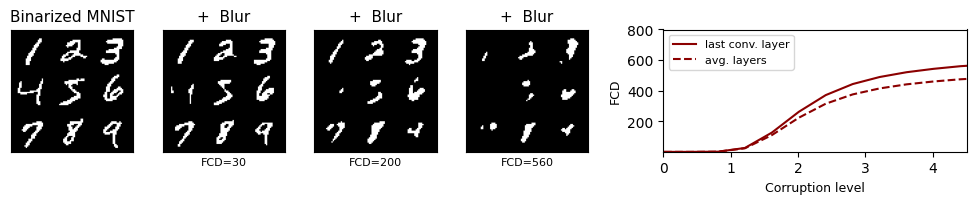

In [306]:
plot_combined_with_mnist_grid(samples=[digits, digits_blur_1, digits_blur_2, digits_blur_3], 
                              fcd_3=fcd_3_blur, 
                              fcd_avg=fcd_avg_blur, 
                              distortion='Blur', 
                              xlim=(0, 4.5),
                              dist_levels=['FCD=0', 'FCD={}'.format(30), 'FCD={}'.format(200), 'FCD={}'.format(560)],
                             figsize=(10, 2))

### 3. Swirl deformation

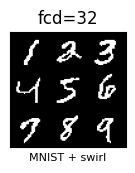

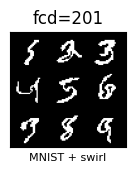

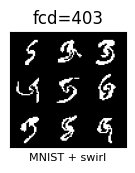

In [307]:
distortion = 'swirl'

level_1 = 1.25

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_1)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion=distortion, values=[level_1], activation_layer='fc3', device=device)
fcd_1 = int(fcd[level_1].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_swirl_1 = get_10_digits(images, labels)
mnist_grid(digits_swirl_1, title='fcd={}'.format(fcd_1), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

level_2 = 2.85

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_2)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion=distortion, values=[level_2], activation_layer='fc3', device=device)
fcd_2 = int(fcd[level_2].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_swirl_2 = get_10_digits(images, labels)
mnist_grid(digits_swirl_2, title='fcd={}'.format(fcd_2), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

level_3 = 4.5

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_3)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion=distortion, values=[level_3], activation_layer='fc3', device=device)
fcd_3 = int(fcd[level_3].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_swirl_3 = get_10_digits(images, labels)
mnist_grid(digits_swirl_3, title='fcd={}'.format(fcd_3), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

In [ ]:
import numpy as np
from fid_metric import fid_distorted_NIST

fcd_1_swirl = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='swirl', values=np.arange(0, 6, 0.3), activation_layer='fc1', device=device)
fcd_2_swirl  = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='swirl', values=np.arange(0, 6, 0.3), activation_layer='fc2', device=device)
fcd_3_swirl  = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='swirl', values=np.arange(0, 6, 0.3), activation_layer='fc3', device=device)
fcd_avg_swirl = {k: (fcd_1_swirl.get(k, 0) + fcd_2_swirl.get(k, 0) + fcd_3_swirl.get(k, 0) ) / 3.0 for k in fcd_1_swirl.keys()}

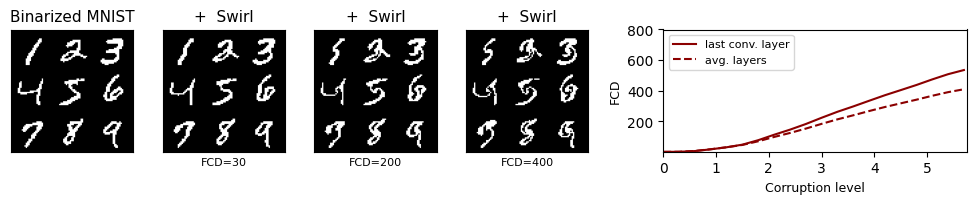

In [308]:
plot_combined_with_mnist_grid(samples=[digits, digits_swirl_1, digits_swirl_2, digits_swirl_3], 
                              fcd_3=fcd_3_swirl, 
                              fcd_avg=fcd_avg_swirl, 
                              distortion='Swirl', 
                              xlim=(0, 5.75),
                              dist_levels=['FCD=0', 'FCD={}'.format(30), 'FCD={}'.format(200),  'FCD={}'.format(400)],
                              figsize=(10, 2))

### 4. Pixelization

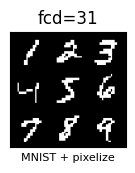

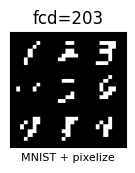

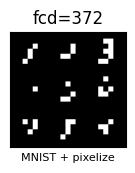

In [309]:
distortion = 'pixelize'

level_1 = 0.4

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_1)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion=distortion, values=[level_1], activation_layer='fc3', device=device)
fcd_1 = int(fcd[level_1].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_pix_1 = get_10_digits(images, labels)
mnist_grid(digits_pix_1, title='fcd={}'.format(fcd_1), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

level_2 = 0.65

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_2)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion=distortion, values=[level_2], activation_layer='fc3', device=device)
fcd_2 = int(fcd[level_2].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_pix_2 = get_10_digits(images, labels)
mnist_grid(digits_pix_2, title='fcd={}'.format(fcd_2), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

level_3 = 0.75

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_3)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion=distortion, values=[level_3], activation_layer='fc3', device=device)
fcd_3 = int(fcd[level_3].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_pix_3= get_10_digits(images, labels)
mnist_grid(digits_pix_3, title='fcd={}'.format(fcd_3), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

In [277]:
import numpy as np
from fid_metric import fid_distorted_NIST

fcd_1_pix = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='pixelize', values=np.arange(0, 1.3, 0.03), activation_layer='fc1', device=device)
fcd_2_pix = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='pixelize', values=np.arange(0, 1.3, 0.03), activation_layer='fc2', device=device)
fcd_3_pix = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='pixelize', values=np.arange(0, 1.3, 0.03), activation_layer='fc3', device=device)

fcd_avg_pix = {k: (fcd_1_pix.get(k, 0) + fcd_2_pix.get(k, 0) + fcd_3_pix.get(k, 0) ) / 3.0 for k in fcd_1_pix.keys()}


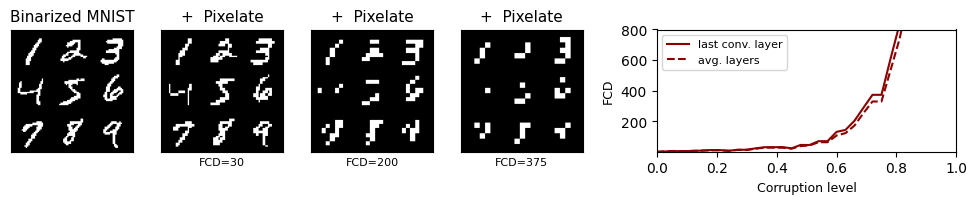

In [310]:
plot_combined_with_mnist_grid(samples=[digits, digits_pix_1, digits_pix_2, digits_pix_3], 
                              fcd_3=fcd_3_pix, 
                              fcd_avg=fcd_avg_pix, 
                              distortion='Pixelate', 
                              xlim=(0, 1.0),
                              dist_levels=['FCD=0', 'FCD={}'.format(30), 'FCD={}'.format(200), 'FCD={}'.format(375)],
                              figsize=(10, 2))

### 6. Crop image

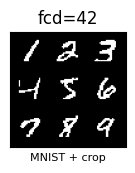

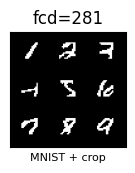

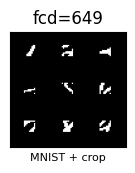

In [311]:
distortion = 'crop'

level_1 = 0.36

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_1)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion=distortion, values=[level_1], activation_layer='fc3', device=device)
fcd_1 = int(fcd[level_1].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_crop_1 = get_10_digits(images, labels)
mnist_grid(digits_crop_1, title='fcd={}'.format(fcd_1), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

level_2 = 0.52

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_2)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion=distortion, values=[level_2], activation_layer='fc3', device=device)
fcd_2 = int(fcd[level_2].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_crop_2 = get_10_digits(images, labels)
mnist_grid(digits_crop_2, title='fcd={}'.format(fcd_2), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

level_3 = 0.65

data = load_nist_data(name='BinaryMNIST', distortion=distortion, level=level_3)
fcd = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion=distortion, values=[level_3], activation_layer='fc3', device=device)
fcd_3 = int(fcd[level_3].item())
dataloader = DataLoader(data, batch_size=100, shuffle=False)
images, labels = next(iter(dataloader))
digits_crop_3 = get_10_digits(images, labels)
mnist_grid(digits_crop_3, title='fcd={}'.format(fcd_3), xlabel='MNIST + ' + distortion, num_img=9, nrow=3, figsize=(1.5,1.5), save=True)

In [201]:
import numpy as np
from fid_metric import fid_distorted_NIST

fcd_1_crop = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='crop', values=np.arange(0, 1.0, 0.03), activation_layer='fc1', device=device)
fcd_2_crop = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='crop', values=np.arange(0, 1.0, 0.03), activation_layer='fc2', device=device)
fcd_3_crop = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='crop', values=np.arange(0, 1.0, 0.03), activation_layer='fc3', device=device)

fcd_avg_crop = {k: (fcd_1_crop.get(k, 0) + fcd_2_crop.get(k, 0) + fcd_3_crop.get(k, 0) ) / 3.0 for k in fcd_1_crop.keys()}

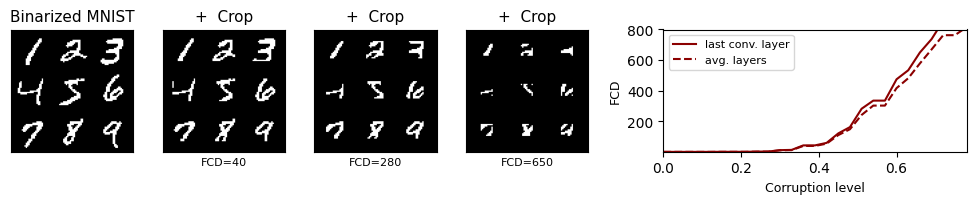

In [316]:
plot_combined_with_mnist_grid(samples=[digits, digits_crop_1, digits_crop_2, digits_crop_3], 
                              fcd_3=fcd_3_crop, 
                              fcd_avg=fcd_avg_crop, 
                              distortion='Crop', 
                              xlim=(0, 0.78),
                              dist_levels=['FCD=0', 'FCD={}'.format(40), 'FCD={}'.format(280),  'FCD={}'.format(650)],
                              figsize=(10, 2))